# Loading and Visualizing the MVTec AD Dataset

In [1]:
import fiftyone as fo
import fiftyone.brain as fob 
import fiftyone.zoo as foz 
from fiftyone import ViewField as F 
import fiftyone.utils.huggingface as fouh 

In [2]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.current_device())  
print(torch.cuda.get_device_name(0)) 

0
NVIDIA GeForce RTX 4060 Laptop GPU


In [3]:
dataset = fouh.load_from_hub("Voxel51/mvtec-ad", persistent=True, overwrite=True)

c:\Users\AD\miniconda3\envs\anomalib_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading dataset
Importing samples...
 100% |███████████████| 5354/5354 [154.0ms elapsed, 0s remaining, 34.8K samples/s]     
Migrating dataset 'Voxel51/mvtec-ad' to v1.2.0



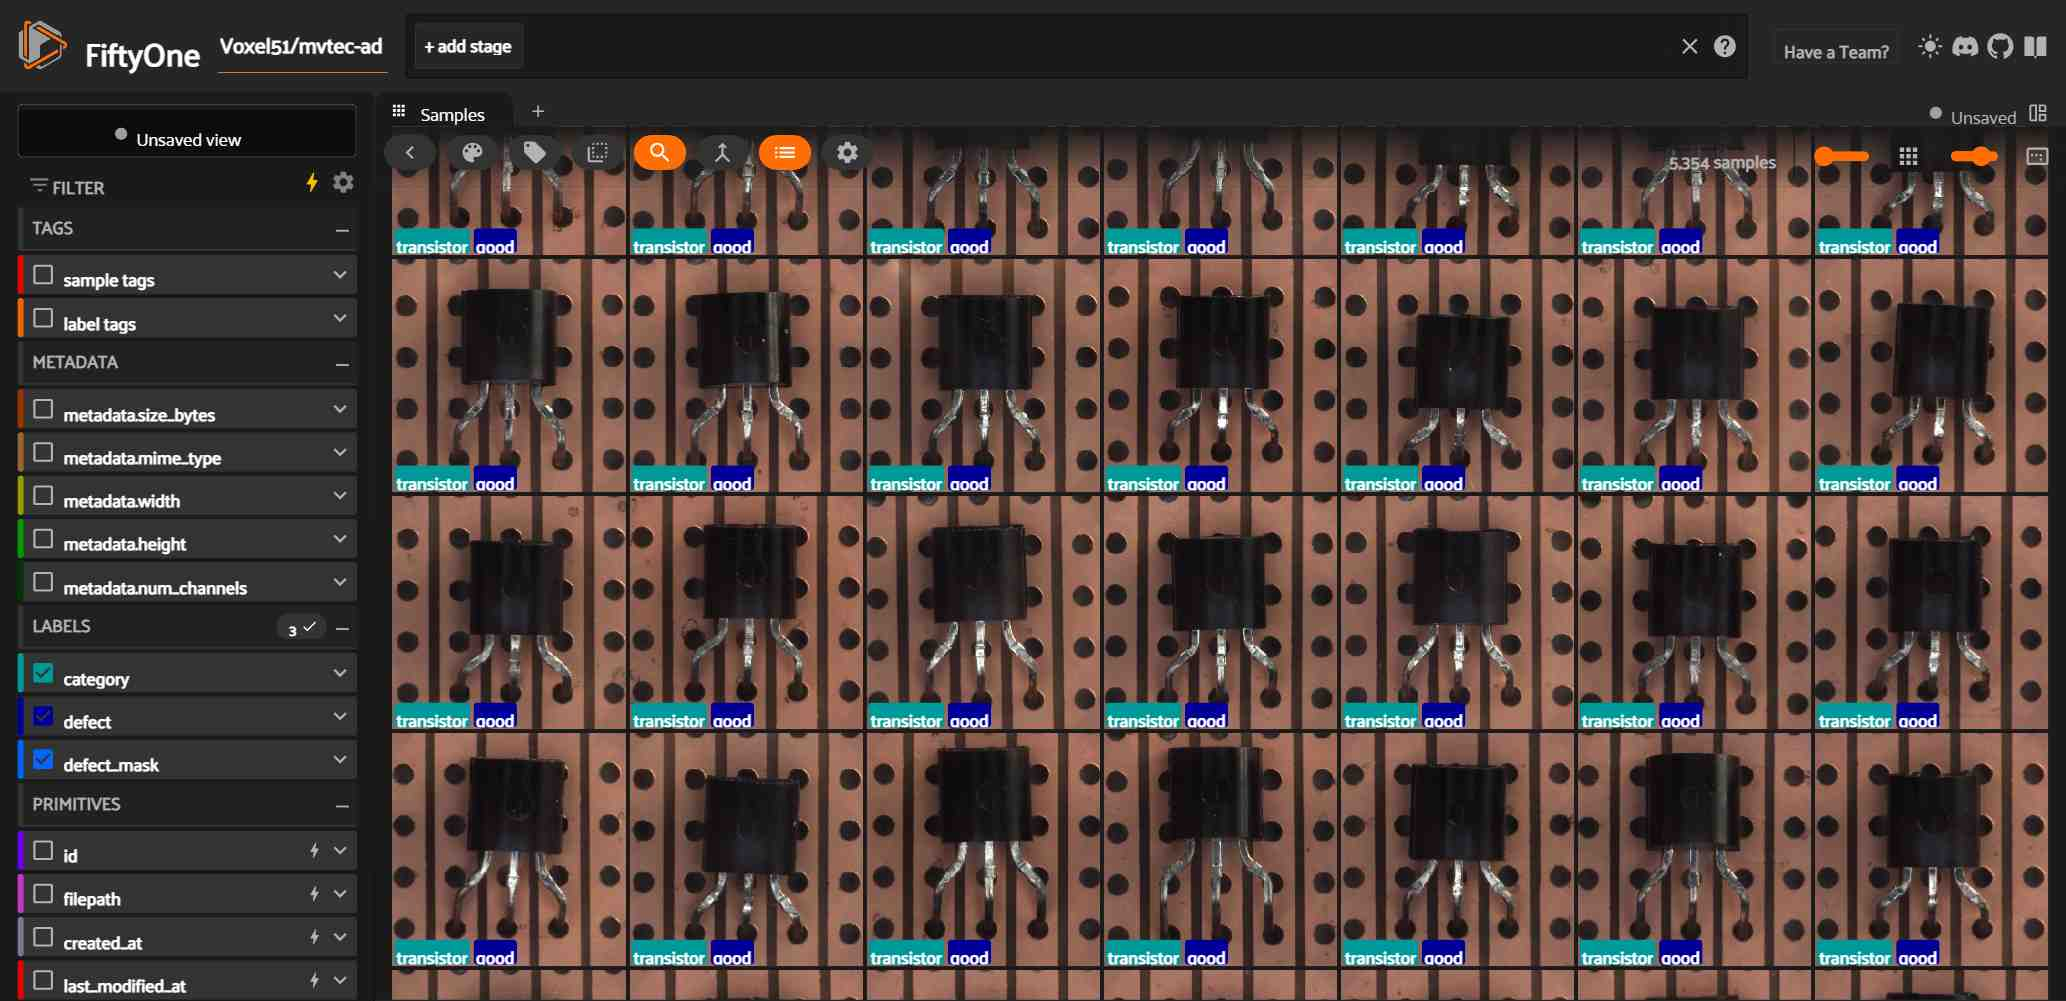

In [4]:
session = fo.launch_app(dataset)

# Test model

In [5]:
from anomalib.deploy import OpenVINOInferencer
from pathlib import Path

# Đường dẫn tới model và metadata
openvino_model_path = Path("D:/anomaly_detection/results/Padim/transistor/latest/weights/openvino/model.bin")
metadata_path = Path("D:/anomaly_detection/results/Padim/transistor/latest/weights/openvino/metadata.json")

# Load inferencer
inferencer = OpenVINOInferencer(
    path=openvino_model_path,
    metadata=metadata_path,
    device="GPU", 
)

In [6]:
from anomalib import TaskType

OBJECT = "transistor" 
ROOT_DIR = Path("D:/anomaly_detection/mvtec_ad") 
TASK = TaskType.SEGMENTATION 
IMAGE_SIZE = (256, 256) 

In [7]:
from PIL import Image

def run_inference(sample_collection, inferencer, key, threshold=0.5):
    for sample in sample_collection.iter_samples(autosave=True, progress=True):
        output = inferencer.predict(image=Image.open(sample.filepath))
        
        conf = output.pred_score
        anomaly = "normal" if conf < threshold else "anomaly"
        sample[f"pred_anomaly_score_{key}"] = conf
        sample[f"pred_anomaly_{key}"] = fo.Classification(label=anomaly)
        sample[f"pred_anomaly_map_{key}"] = fo.Heatmap(map=output.anomaly_map)
        sample[f"pred_defect_mask_{key}"] = fo.Segmentation(mask=output.pred_mask)

In [ ]:
test_split = dataset.match(F("category.label") == OBJECT).match(F("split") == "test")
run_inference(test_split, inferencer, "padim")
session = fo.launch_app(view=test_split)

 100% |█████████████████| 100/100 [37.5s elapsed, 0s remaining, 3.1 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 100/100 [37.5s elapsed, 0s remaining, 3.1 samples/s]      
